### Use the Asynchronous Advantage Actor Critic (A3C) Policy Gradient Method to solve Breakout

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter
from collections import deque
import progressbar as pb
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from parallelEnv import parallelEnv

In [37]:
env_id = 'Breakout-v4'
env = gym.make(env_id)

In [38]:
env.observation_space

Box(210, 160, 3)

In [4]:
print(f"Actions:{env.action_space}\nMeanings:{env.unwrapped.get_action_meanings()}")

Actions:Discrete(6)
Meanings:['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #convert to GPU if available

## Preprocess Image

In [6]:
## Utils
def preprocess_single_frame(image, bkg_color = np.array([144, 72, 17])):
    """
    Converts an image from RGB channel to B&W channels.
    Also performs downscale to 80x80. Performs normalization.
    @Param:
    1. image: (array_like) input image. shape = (210, 160, 3)
    2. bkg_color: (np.array) standard encoding for brown in RGB with alpha = 0.0
    @Return:
    - img: (array_like) B&W, downscaled, normalized image of shape (80x80)
    """
    img = np.mean(image[35:195:2,::2]-bkg_color, axis=-1)/255.
    return img

#Utils
def preprocess_batch(images, bkg_color = np.array([144, 72, 17])):
    """
    convert outputs of parallelEnv to inputs to pytorch neural net"""
    list_of_images = np.asarray(images)
    if len(list_of_images.shape) < 5:
        list_of_images = np.expand_dims(list_of_images, 1)
    # subtract bkg and crop
    list_of_images_prepro = np.mean(list_of_images[:,:,34:-16:2,::2]-bkg_color,
                                    axis=-1)/255.
    batch_input = np.swapaxes(list_of_images_prepro,0,1)
    return torch.from_numpy(batch_input).float().to(device)

In [7]:
state = env.reset()
for _ in range(20):#skip 20 frames
    frame, _, _, _ = env.step(np.random.randint(0, env.action_space.n))

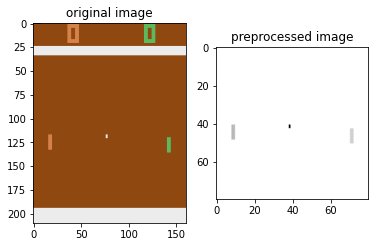

In [8]:
#Plot processed and raw image
plt.subplot(1,2,1)
plt.imshow(frame)
plt.title('original image')

plt.subplot(1,2,2)
plt.title('preprocessed image')
# 80 x 80 black and white image
plt.imshow(preprocess_single_frame(frame), cmap='Greys')
plt.show()

# Actor-Critic

![actor critic achitecture](https://www.mdpi.com/energies/energies-09-00725/article_deploy/html/images/energies-09-00725-g001-1024.png)

In [9]:
#DEFINE Constants
GAMMA = 0.99
TAU = 1.0
LR = 0.5*1e-4
MAX_EPISODE_LENGTH = 1e8
BETA = 0.01 #entropy coefficient

In [10]:
class ActorCritic(nn.Module):
    def __init__(self, action_size=4, num_frames=2):
        super(ActorCritic, self).__init__()
        self.action_size = action_size
        
        #Define the CNN for Actor & Critic
        self.conv1 = nn.Conv2d(num_frames, 32, 3, stride=2, padding=1) #output = 40x40x32
        self.conv2 = nn.Conv2d(32, 32, 3, stride=2, padding=1) #output = 20x20x32
        self.conv3 = nn.Conv2d(32, 32, 3, stride=2, padding=1) #output = 10x10x32
        self.conv4 = nn.Conv2d(32, 32, 3, stride=2, padding=1) #output = 5x5x32
        
        self.size = 5*5*32 #800

        #FC layer
        self.lstm = nn.LSTMCell(input_size=self.size, hidden_size=256)#lstm cell to prevent vanishing gradients
        
        # Define Actor and Critic network
        # Critic evaluates the state value function, V(π) using TD estimate.
        # Actor evaluates the policy π(a|s) distribution
        
        self.critic_linear, self.actor_linear = nn.Linear(256, 1), nn.Linear(256, self.action_size)
        
    def forward(self, x, hx, cx):
        """
        Peforms one-pass for the Conv layers.
        @Param:
        1. x - shape: (2, 80, 80); 2 stacked frames of 80x80 images
        2. hx - hidden state of the RNN. shape: (1x256)
        3. cx - confidence state of the RNN. shape: (1x256)
        @Return:
        1. critic estimated value, V(π)
        2. actor policy distribution, π(a|s) as logits
        """
        #4 conv nets without max pool layers, simple Relu activation f(x)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(-1,self.size) #flatten
        hx, cx = self.lstm(x, (hx, cx)) #dynamic calculation for final confidence & hidden state
        value = self.critic_linear(hx) #CRITIC: calculates estimated state value function, V(π)
        logits = self.actor_linear(hx) #ACTOR:  calculates policy distribution π(a|s)
        
        return logits, value, hx, cx

In [11]:
main_model = ActorCritic(num_frames=1)

In [12]:
main_model

ActorCritic(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (lstm): LSTMCell(800, 256)
  (critic_linear): Linear(in_features=256, out_features=1, bias=True)
  (actor_linear): Linear(in_features=256, out_features=4, bias=True)
)

# Optimizer
<p> A critical component to an A3C model is the ability to share parameters across
    multiple agents running asynchronously such that they can collectively learn from
    each other. This is done by the cross-integration (sharing) of gradients across all processes.
</p>

In [13]:
class SharedOptimizer(optim.Adam):
    """Implementation of shared parameter model using Adam optimizer"""
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        super(SharedOptimizer, self).__init__(params, lr, betas, eps, weight_decay)
        for group in self.param_groups:
            for p in group['params']:
                state = self.state[p]
                state['shared_steps'], state['step'] = torch.zeros(1).share_memory_(), 0
                state['exp_avg'] = p.data.new().resize_as_(p.data).zero_().share_memory_()
                state['exp_avg_sq'] = p.data.new().resize_as_(p.data).zero_().share_memory_()
                
        def step(self, closure=None):
            for group in self.param_groups:
                for p in group['params']:
                    if p.grad is None: continue
                    self.state[p]['shared_steps'] += 1
                    self.state[p]['step'] = self.state[p]['shared_steps'][0] - 1 # a "step += 1"  comes later
            super.step(closure)

In [14]:
optimizer = SharedOptimizer(main_model.parameters()) #define optimizer (uses Adam, instead of SGD)

## Generalized Advantage Estimator 
<br>
<p>
    Generalized Advantage Estimator (GAE) helps us pick the best value for N-step boostrapping
    by incorporating λ as an added hyper-parameter to tune accordingly that will minimize the
    bias-variance tradeoff.
    <br>
    The derivation can be thought of as <a href="https://danieltakeshi.github.io/2017/04/02/notes-on-the-generalized-advantage-estimation-paper/#the-generalized-advantage-estimator">the exponentially-decayed sum of residual terms.</a>
</p>
<p><strong>See the following <a href="https://arxiv.org/pdf/1506.02438.pdf">derivation</a> for GAE estimator:</strong></p>

![GAE Derivation](https://res.cloudinary.com/crammer/image/upload/v1596251771/Screen_Shot_2020-07-31_at_11.15.47_PM_feuhld.png)

In [15]:
discount = lambda x, gamma: lfilter([1],[1,-gamma],x[::-1])[::-1] # computes discounted reward

In [16]:
def compute_cost(values, log_probs, actions, rewards, n=8):
    """
    Calculates the policy (actor) and value (critic) loss
    @Param:
    1. values: (tensor) list of V(s) estimator, critic.
    2. log_probs: (tensor) list of π(a|s) softmax output, actor.
    3. actions: (tensor) actions taken from rollout of trajectory.
    4. rewards: (tensor) rewards based on S,A pairs. true values, used to minimize loss.
    5. gae_lambda: (float) [0-1] value of lambda for residual calculation. used in N-step bootstrap.
    6. n: (int) number of parallel agents.
    @Return:
    - value_loss: (tensor) critic loss.
    - policy_loss: (tensor) actor loss.
    """
    np_values = values.view(-1).data.numpy() #convert torch.tensor to numpy array & flatten/reshape it
    #implement GAE
    rewards = torch.tensor(rewards).view(-1,1).squeeze(-1) # (20x8) --> (160)
    delta_t =  + GAMMA * (np_values[n:] - np_values[:-n])
    
    log_probs = log_probs.gather(1, torch.tensor(actions).view(-1,1))
    gae = discount(delta_t, GAMMA * TAU)#calculate Generative Advantage Estimate

    #calculate policy_loss = -log( π(a|s) ) * ( R - V(s) )
    policy_loss = -(log_probs.view(-1) * torch.FloatTensor(gae.copy())).sum()
    
    # l2 loss over value estimator
    rewards[-1] += GAMMA * np_values[-n]
    discounted_r = discount(np.asarray(rewards), GAMMA)
    discounted_r = torch.tensor(discounted_r.copy(), dtype=torch.float32)
    
    value_loss = 0.5*(discounted_r - values[:-n,0]).pow(2).sum()

    entropy_loss = (-log_probs * torch.exp(log_probs)).sum() # entropy = ∑ -log(π(a|s))*e^(log(π(a|s)))
    return policy_loss + 0.5 * value_loss - BETA * entropy_loss
#     return policy_loss - value_loss -  BETA * entropy_loss #total loss

## Train

In [17]:
# Utils
def sync_models(model, shared_model, i, pprint):
    """
    Syncs the gradients from local model to shared model as a critical part of the A3C algorithm.
    Updates the pointer based reference.
    @param:
    1. model: local model to sync from.
    2. shared_model: global model to sync into.
    3. i: episode number. Used in calculation of when to save the local model.
    4. pprint: model iteration to save, i.e. saves model when i%pprint = 0.
    """
    if(i%pprint == 0): #Save weights
        model_path = "models/model_" + str(i//pprint) + "_.pth"
        torch.save(model.state_dict(), model_path)
        
    for local_param, shared_param in zip(model.parameters(), shared_model.parameters()):
        if(shared_param.grad is not None):
            return
        shared_param.grad = local_param.grad #sync

In [18]:
def get_stacked_frame(envs, n, reset=True):
    """
    Returns a 1x2x80x80 tensor by concatenating 2 processed frames.
    @Param:
    - reset: (boolean, optional) if True, gets the first 2 frames of the env.
    @return:
    - state: a 1x2x80x80 torch.Tensor
    - frame0: first frame of size 80x80 
    - frame1: second frame of size 80x80 
    """
    frame0 = envs.reset()
#     frame1,_,_,_ = envs.step([1]*n) #fire
    state = preprocess_batch([frame0]) #nx1x80x80 tensor
    return state, frame0

In [39]:
def train(shared_model, envs, optimizer=None, num_episode=1000, num_steps=50, print_every=100):
    """
    Train A3C agent.
    @Param:
    1. shared_model: instance of ActorCritic class, globally shared model across all parallel agents.
    2. envs: parallel agents.
    3. optimizer: instance of SharedOptimizer class, default = None (created as local object).
    4. num_episode: (int) number of episodes to train for.
    5. num_steps: (int) number of forward pass to pass through. default = 20.
    6. print_every: (int) display statistics & save weights every n episodes. default = 100.
    @Return:
    - overall_reward: total reward per episode.
    - overall_cost: total cost based on the custom loss function over num_episode.
    - loss_deque: the N most recent loss values. default = 100.
    """
    # widget bar to display progress
    widget = ['training loop: ', pb.Percentage(), ' ', 
              pb.Bar(), ' ', pb.ETA() ]
    timer = pb.ProgressBar(widgets=widget, maxval=num_episode).start()
    
    # number of parallel instances
    n = len(envs.ps)
    
    model = ActorCritic(num_frames=1) #local model
    
    if(optimizer is None):#create optimizer
        optimizer = SharedOptimizer(shared_model.parameters(), lr=LR)
    
    model.train()#Set the local model in training mode
    
    #Extract stacked frames
    
    state, frame0 = get_stacked_frame(envs, n)# (nx2x80x80) Tensor
    episode_length = 0
    done = np.full(8, True)
    
    #return metrics
    overall_reward = []
    overall_cost = []
    loss_deque = deque(maxlen=100)
    score_deque = deque(maxlen=100)
    
    for i in range(1, num_episode+1):
        model.load_state_dict(shared_model.state_dict()) #syncs the shared model with the local model
            
        if done.any():
            cx, hx = torch.zeros(n, 256), torch.zeros(n, 256)
        else:
            cx = cx.detach()
            hx = hx.detach()
        
        values = []; log_probs = []; rewards = []; actions = []
        for step in range(num_steps):
            episode_length += 1
            logits, value, hx, cx = model(state, hx, cx)
            prob = F.softmax(logits, dim=-1)
            log_prob = F.log_softmax(logits, dim=-1)
            
            action = [torch.exp(log_prob[i]).multinomial(num_samples=1).item() for i in range(n)]
            frame0, reward, done, _ = envs.step([action]*n)
#             frame1, r, done, _ = envs.step([0]*n)

            #stack frames to an nx2x80x80 Tensor
            state = preprocess_batch([frame0])
            
            #update data
            values.append(value.detach())
            log_probs.append(log_prob)
            rewards.append(reward)
            actions.append(action)
                        
            if done.any() or episode_length > MAX_EPISODE_LENGTH:
                episode_length = 0
                state, frame0 = get_stacked_frame(envs, n)#nx2x80x80 Tensor
                break
        overall_reward.append(sum(rewards)) #cumulitive reward per episode
        score_deque.append(overall_reward) #last 100 score
    
        #Solves broadcasting error
        next_value = torch.zeros(n,1) if done.any() else model(state, hx, cx)[1] #return value
        values.append(next_value.detach())

        #compute loss
        loss = -compute_cost(torch.cat(values), torch.cat(log_probs), actions, rewards, n=n)
        overall_cost.append(loss.item())
        loss_deque.append(loss.item()) #last 100 losses
        if(i%print_every == 0):
            print("Episode: {0:d}, cost: {1:f}, score: {2:f}".format(i,np.mean(loss_deque), np.mean(score_deque)))
            print(overall_reward[-1])
        # update progress widget bar
        timer.update(i)
        
        optimizer.zero_grad()#reset gradient
        loss.backward() #perform backprop

        #synchronize shared_model with local_model
        sync_models(model, shared_model, i, print_every)

        #Perform single forward step
        optimizer.step()
    
    timer.finish()
    
    return overall_reward, overall_cost, loss_deque

## Parallelization

In [40]:
# load mulitple parallel agents, in this case 16.
envs = parallelEnv(env_id, n=1, seed=1)

Process Process-5:
Traceback (most recent call last):
  File "/Users/qasimwani/opt/anaconda3/envs/drlnd/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/qasimwani/opt/anaconda3/envs/drlnd/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/qasimwani/Desktop/Nous/reinforcement_learning/personal_projects/policy-value-methods/Actor-Critic/parallelEnv.py", line 101, in worker
    cmd, data = remote.recv()
  File "/Users/qasimwani/opt/anaconda3/envs/drlnd/lib/python3.6/multiprocessing/connection.py", line 250, in recv
    buf = self._recv_bytes()
  File "/Users/qasimwani/opt/anaconda3/envs/drlnd/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/Users/qasimwani/opt/anaconda3/envs/drlnd/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


In [41]:
overall_reward, overall_cost, loss_deque = train(main_model, envs, num_episode=1000, print_every=50)

Episode: 50, cost: -1.187335, score: 0.140000
[0.]


Episode: 100, cost: -1.567697, score: 0.240000
[1.]


Episode: 150, cost: -1.755188, score: 0.240000
[0.]


Episode: 200, cost: -1.583361, score: 0.235000
[1.]


Episode: 250, cost: -1.588733, score: 0.236000
[0.]


Episode: 300, cost: -1.359808, score: 0.233333
[0.]


Episode: 350, cost: -1.100828, score: 0.228571
[0.]


Episode: 400, cost: -1.368583, score: 0.240000
[1.]


Episode: 450, cost: -1.692520, score: 0.248889
[0.]


Episode: 500, cost: -1.776769, score: 0.254000
[1.]


Episode: 550, cost: -1.799795, score: 0.258182
[0.]


Episode: 600, cost: -1.563676, score: 0.256667
[0.]


Episode: 650, cost: -1.445733, score: 0.256923
[0.]


Episode: 700, cost: -1.500919, score: 0.257143
[0.]


Episode: 750, cost: -1.719661, score: 0.261333
[0.]


Episode: 800, cost: -1.594444, score: 0.255000
[1.]


Episode: 850, cost: -1.385341, score: 0.254118
[1.]


Episode: 900, cost: -1.266788, score: 0.247778
[0.]


Episode: 950, cost: -1.070479, score: 0.242105
[0.]


Episode: 1000, cost: -1.523067, score: 0.242000
[1.]


training loop: 100% |###########################################| Time: 0:05:46


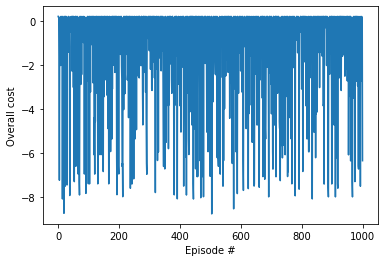

In [42]:
plt.plot(overall_cost)
plt.xlabel("Episode #")
plt.ylabel("Overall cost")
plt.show()

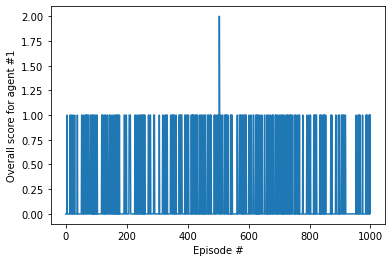

In [43]:
plt.plot(np.array(overall_reward).T[0])#reward for agent #1
plt.xlabel("Episode #")
plt.ylabel("Overall score for agent #1")
plt.show()

In [47]:
def test():
    # state, frame0, frame1 = get_stacked_frame()
    frame0 = env.reset()
#     env.step(1) #fire
#     frame1 = env.step(0)[0]
    total_reward = 0 #reward per frame stacked

    # # perform nrand random steps in the beginning
    # for _ in range(5):
    #     frame1, reward1, is_done, _ = env.step(np.random.choice([RIGHT,LEFT]))
    #     frame2, reward2, is_done, _ = env.step(0)
    done = True
    actions = []
    for _ in range(1000):

        if done:
            cx, hx = torch.zeros(1, 256), torch.zeros(1, 256)
        else:
            cx = cx.detach()
            hx = hx.detach()

        state = preprocess_batch([frame0])     

        logits, value, hx, cx = main_model(state, hx, cx)

        log_prob = F.softmax(logits, dim=-1)
        action = torch.exp(log_prob).multinomial(num_samples=1).item()
        frame0, r1, is_done, _ = env.step(action)


        actions.append(action)
        total_reward += r1
        env.render()

        if is_done:
            break

    return total_reward, actions

In [ ]:
time.sleep(1)
for i in range(10):
    tr, _ = test()
    print(f"Reward for test run #{i+1}: {tr}")

Reward for test run #1: 1.0
Reward for test run #2: 3.0
Reward for test run #3: 1.0
Reward for test run #4: 2.0
Reward for test run #5: 1.0


## Analysis

In [26]:
#TODO